## Описание проекта

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

##  Загрузка данных и подготовка их к анализу

Подключаем библиотеки, которые понадобятся для работы над проектом

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import datetime

Откроем файлы с данными и изучим общую информацию

In [55]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

for data in [calls, internet, messages, users, tariffs]: print(data.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns

Проверим дубликаты в таблице с клиентами

In [56]:
print("Число дубликатов:", users.duplicated().sum())
print("Число дубликатов:", calls.duplicated().sum())
print("Число дубликатов:", internet.duplicated().sum())
print("Число дубликатов:", messages.duplicated().sum())
print("Число дубликатов:", tariffs.duplicated().sum())

Число дубликатов: 0
Число дубликатов: 0
Число дубликатов: 0
Число дубликатов: 0
Число дубликатов: 0


Как можно увидеть, ни в одной из таблиц не имеется дубликатов.

Если посмотреть на все таблицы, то можем увидеть проблему с типом данных в некоторых столбцах с датой. Также прочитав примечание из задачи, поставленной в проекте, нам нужно округлить длительность разговора и количество использованного интернет-трафика в большую сторону.

Заменим тип данных в столбцах, которые содержат дату, с `object` на `datetime`

In [57]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

Все звонки длительностью меньше минуты запишем, как 1 минута

In [58]:
print(calls['duration'])

0          0.00
1          0.00
2          2.85
3         13.80
4          5.18
          ...  
202602     0.76
202603    18.83
202604    10.81
202605     4.27
202606    19.62
Name: duration, Length: 202607, dtype: float64


Воспользуемся функцией `ceil` из библиотеки math

In [59]:
calls['duration'] = calls['duration'].apply(np.ceil)
print(calls['duration'])

0          0.0
1          0.0
2          3.0
3         14.0
4          6.0
          ... 
202602     1.0
202603    19.0
202604    11.0
202605     5.0
202606    20.0
Name: duration, Length: 202607, dtype: float64


Проанализируем аномалии в таблице с интернет-трафиком и построим гистограмму

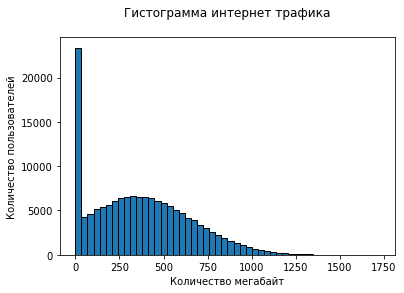

In [60]:
internet['mb_used'].plot(kind='hist', ec='black', bins=50)
plt.title('Гистограмма интернет трафика'+ "\n")
plt.xlabel('Количество мегабайт')
plt.ylabel('Количество пользователей')
plt.show()

Посмотрим на количество строк с нулевым интернет-трафиком

In [61]:
internet.query('mb_used == 0')

,Unnamed: 0,id,mb_used,session_date,user_id
11,11,1000_11,0.0,2018-08-28,1000
38,38,1000_38,0.0,2018-11-27,1000
46,46,1000_46,0.0,2018-06-30,1000
67,67,1000_67,0.0,2018-06-16,1000
72,72,1000_72,0.0,2018-06-15,1000
...,...,...,...,...,...
149380,149380,1499_141,0.0,2018-12-11,1499
149381,149381,1499_142,0.0,2018-11-01,1499
149383,149383,1499_144,0.0,2018-11-27,1499
149386,149386,1499_147,0.0,2018-10-21,1499


Таких строк почти 20 тысяч. Такое может случится, если, например, человек хотел зайти в интернет, но у него в этот момент пропала связь, и сессия была закончена. Уберем нулевые значения.

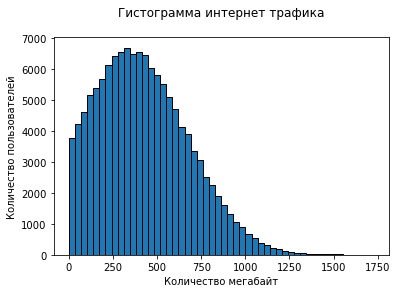

In [62]:
internet['mb_used'] = internet['mb_used'].replace(0, np.NaN)
internet = internet.dropna()
internet['mb_used'].plot(kind='hist', ec='black', bins=50)
plt.title('Гистограмма интернет трафика'+ "\n")
plt.xlabel('Количество мегабайт')
plt.ylabel('Количество пользователей')
plt.show()

Тем самым мы убрали значения, которые никак не помогут нам в анализе.

**Посчитаем для каждого пользователя:**

- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Для начала сделаем таблицу по звонкам

In [63]:
# Комментарий ревьюера
# Создадим копии датасетов
temp_c = calls.copy()
temp_i = internet.copy()
temp_m = messages.copy()

In [64]:
temp_c['month'] = temp_c['call_date'].dt.month
temp_c_m = temp_c.pivot_table(index = ['user_id', 'month'], values = 'duration', aggfunc = ['count', 'sum']).reset_index()
temp_c_m.columns = ['user_id', 'month', 'calls_count', 'calls_sum']
temp_c_m.head(10)

,user_id,month,calls_count,calls_sum
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0
5,1000,10,57,350.0
6,1000,11,43,338.0
7,1000,12,46,333.0
8,1001,11,59,430.0
9,1001,12,63,414.0


Сделаем такую же таблицу для сообщений

In [65]:
temp_m['month'] = temp_m['message_date'].dt.month
temp_m_m = temp_m.pivot_table(index = ['user_id', 'month'], values = 'id' , aggfunc = ['count']).reset_index()
temp_m_m.columns = ['user_id', 'month', 'message_count']
temp_m_m.head(10)

,user_id,month,message_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


И такую же таблицу для интернет-трафика

In [66]:
temp_i['month'] = temp_i['session_date'].dt.month
temp_i_m = temp_i.pivot_table(index = ['user_id', 'month'], values = 'mb_used' , aggfunc = ['sum']).reset_index()
temp_i_m.columns = ['user_id', 'month', 'mb_sum_internet']
temp_i_m['gb_sum_internet'] = temp_i_m['mb_sum_internet'] / 1024 
temp_i_m['gb_sum_internet'] = temp_i_m['gb_sum_internet'].apply(np.ceil)
temp_i_m.head()

,user_id,month,mb_sum_internet,gb_sum_internet
0,1000,5,2253.49,3.0
1,1000,6,23233.77,23.0
2,1000,7,14003.64,14.0
3,1000,8,14055.93,14.0
4,1000,9,14568.91,15.0


Теперь объединяем все эти таблицы в одну

In [67]:
revenue = temp_c_m.merge(temp_m_m, on = ['user_id', 'month'], how = 'outer')
revenue = revenue.merge(temp_i_m, on = ['user_id', 'month'], how = 'outer')
revenue = revenue.merge(users[['user_id','tariff','city']], on = ['user_id'], how = 'outer')
revenue = revenue.fillna(0)
revenue.head()

,user_id,month,calls_count,calls_sum,message_count,mb_sum_internet,gb_sum_internet,tariff,city
0,1000,5.0,22.0,159.0,22.0,2253.49,3.0,ultra,Краснодар
1,1000,6.0,43.0,172.0,60.0,23233.77,23.0,ultra,Краснодар
2,1000,7.0,47.0,340.0,75.0,14003.64,14.0,ultra,Краснодар
3,1000,8.0,52.0,408.0,81.0,14055.93,14.0,ultra,Краснодар
4,1000,9.0,58.0,466.0,57.0,14568.91,15.0,ultra,Краснодар


Посчитаем помесячную выручку с каждого пользователя

In [68]:
def det_revenue(row):
    messages = row['message_count']
    mb_used = row['mb_sum_internet']
    tariff = row['tariff']
    duration = row['calls_sum']
    calls = row['calls_count']
    if tariff == 'smart':
        extra_duration = duration - tariffs.loc[0, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[0, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[0, 'messages_included']
        if extra_duration <= 0: extra_duration = 0
        if extra_mb <= 0: extra_mb = 0
        if extra_messages <= 0: extra_messages = 0
        return (tariffs.loc[0, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[0, 'rub_per_gb'] / 1024) * extra_mb + 
                   tariffs.loc[0, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[0, 'rub_monthly_fee']
                  ) 
    else:
        extra_duration = duration - tariffs.loc[1, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[1, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[1, 'messages_included']
        if extra_duration <= 0: extra_duration = 0
        if extra_mb <= 0: extra_mb = 0
        if extra_messages <= 0: extra_messages = 0
        return (tariffs.loc[1, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[1, 'rub_per_gb'] / 1024) * extra_mb + 
                   tariffs.loc[1, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[1, 'rub_monthly_fee']
                  )

revenue['monthly_revenue'] = revenue.apply(det_revenue, axis=1)
revenue.head(10)

,user_id,month,calls_count,calls_sum,message_count,mb_sum_internet,gb_sum_internet,tariff,city,monthly_revenue
0,1000,5.0,22.0,159.0,22.0,2253.49,3.0,ultra,Краснодар,1950.000000
1,1000,6.0,43.0,172.0,60.0,23233.77,23.0,ultra,Краснодар,1950.000000
2,1000,7.0,47.0,340.0,75.0,14003.64,14.0,ultra,Краснодар,1950.000000
3,1000,8.0,52.0,408.0,81.0,14055.93,14.0,ultra,Краснодар,1950.000000
4,1000,9.0,58.0,466.0,57.0,14568.91,15.0,ultra,Краснодар,1950.000000
5,1000,10.0,57.0,350.0,73.0,14702.49,15.0,ultra,Краснодар,1950.000000
6,1000,11.0,43.0,338.0,58.0,14756.47,15.0,ultra,Краснодар,1950.000000
7,1000,12.0,46.0,333.0,70.0,9817.61,10.0,ultra,Краснодар,1950.000000
8,1001,11.0,59.0,430.0,0.0,18429.34,18.0,smart,Москва,1149.480469
9,1001,12.0,63.0,414.0,0.0,14036.66,14.0,smart,Москва,550.000000


## Проанализируйте данные

Посчитаем сколько минут разговора, сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц

In [69]:
medians = revenue.pivot_table(index='user_id', values=['calls_sum', 'message_count', 'gb_sum_internet', 'monthly_revenue'],aggfunc='median')
medians = medians.merge(users[['user_id','tariff']], on = ['user_id'], how = 'outer')
medians.head()

,user_id,calls_sum,gb_sum_internet,message_count,monthly_revenue,tariff
0,1000,339.0,14.5,65.0,1950.000000,ultra
1,1001,422.0,16.0,0.0,849.740234,smart
2,1002,214.0,18.0,11.0,983.613281,smart
3,1003,824.0,12.0,83.0,1950.000000,ultra
4,1004,132.5,18.0,154.5,1950.000000,ultra


Посчитаем дисперсию, среднее и стандартное отклонение для звонков, сообщений и интернета.

In [70]:
statistic = revenue.pivot_table(index=['tariff'], values=['calls_sum', 'gb_sum_internet', 'message_count'], 
                    aggfunc={'calls_sum': [np.mean, np.var, np.std], 
                             'gb_sum_internet': [np.mean, np.var, np.std], 
                             'message_count': [np.mean, np.var, np.std]})
statistic.head()

calls_sum                            gb_sum_internet            \
              mean         std            var            mean       std   
tariff                                                                    
smart   417.747534  190.476754   36281.393836       16.321525  5.756167   
ultra   526.089249  317.887549  101052.493549       19.474645  9.868057   

                  message_count                          
              var          mean        std          var  
tariff                                                   
smart   33.133453     33.369058  28.230396   796.955256  
ultra   97.378544     49.313387  47.806040  2285.417425

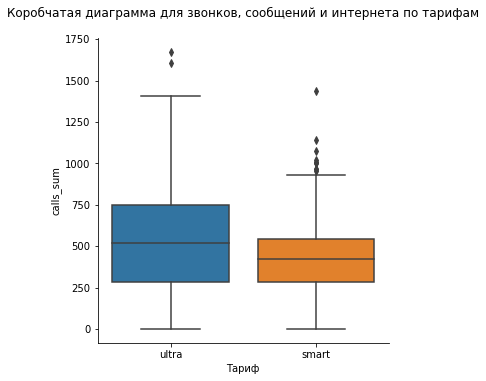

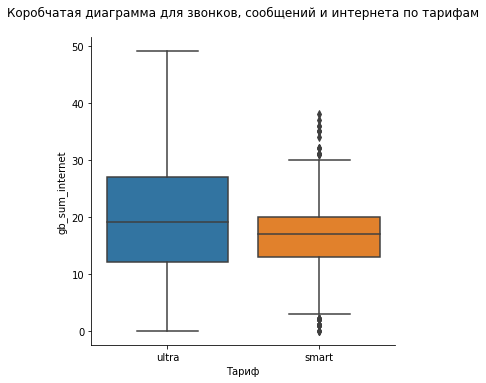

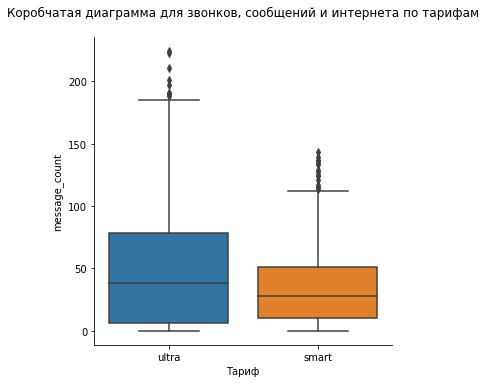

In [71]:
for column in ['calls_sum', 'gb_sum_internet', 'message_count']:    
    sns.catplot(x="tariff", y=column, kind="box", data=revenue)
    plt.title('Коробчатая диаграмма для звонков, сообщений и интернета по тарифам'+ "\n")
    plt.xlabel('Тариф')
    plt.show()

Как можно увидеть среднеее и дисперсия более дорого тарифа `Ультра` больше, чем дисперсия и медиана тарифа `Смарт`. С помощью boxplot можно увидеть, что более дешевый тариф имеет выбросы по всем категориям, которые мы рассматриваем. Также медианы дорогого тарифа по звонкам и интернету смещены в большую стороны, нежели у дешевого тарифа.

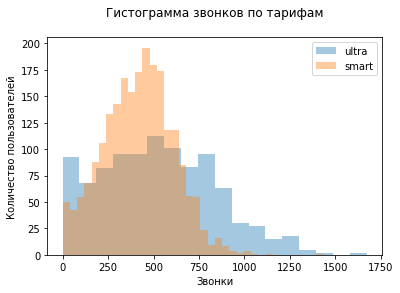

In [72]:
for tariff in ['ultra', 'smart']:
    sns.distplot(revenue.query('tariff == @tariff')['calls_sum'], kde=False, label=tariff)
plt.legend(['ultra', 'smart']) 
plt.title('Гистограмма звонков по тарифам'+ "\n")
plt.xlabel('Звонки')
plt.ylabel('Количество пользователей')
plt.show()
import warnings
warnings.filterwarnings("ignore")

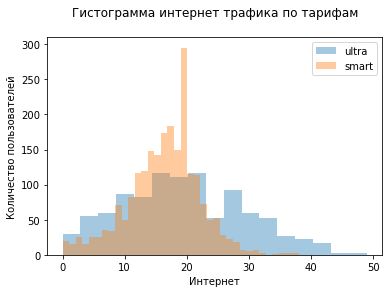

In [73]:
for tariff in ['ultra', 'smart']:
    sns.distplot(revenue.query('tariff == @tariff')['gb_sum_internet'], kde=False, label=tariff)
plt.legend(['ultra', 'smart'])
plt.title('Гистограмма интернет трафика по тарифам'+ "\n")
plt.xlabel('Интернет')
plt.ylabel('Количество пользователей')
plt.show()

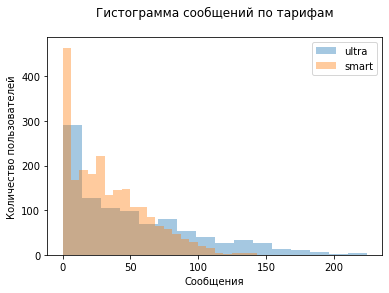

In [74]:
for tariff in ['ultra', 'smart']:
    sns.distplot(revenue.query('tariff == @tariff')['message_count'], kde=False, label=tariff)
plt.legend(['ultra', 'smart'])
plt.title('Гистограмма сообщений по тарифам'+ "\n")
plt.xlabel('Сообщения')
plt.ylabel('Количество пользователей')
plt.show()

Если обобщить комментарии по каждому из трех графиков, то можно сделать вывод, что пользователи тарифа `Ультра` более гибкие в плане использования услуг. То есть благодаря большему запасу минут разговора, интернет-трафика и сообщений они могут не думать о том, что у них может что то закончиться, и они выйдут за рамки тарифа. А вот с дешевым тарифом ситуация иная, по графикам видно, что большая часть сконцентрирована в одном месте, то есть люди пользуются им примерно одинаково.

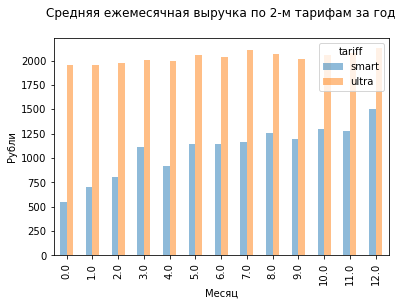

In [75]:
revenue.pivot_table(index='tariff', columns='month', values='monthly_revenue', aggfunc='mean').T.plot(kind='bar', alpha=0.5)
plt.title('Средняя ежемесячная выручка по 2-м тарифам за год'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('Рубли')
plt.show()

По средней ежемесячной выручке мы можем увидеть положительную динамику у более дешевого тарифа, который в перспективе может обогнать в будущем по выручке более дорогой тариф.

## Проверка гипотез

- Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

H0 - Средняя выручка пользователей тарифов не отличается<br>
H1 - Отличается

In [76]:
ultra = revenue.query('tariff == "ultra"')['monthly_revenue']
smart = revenue.query('tariff == "smart"')['monthly_revenue']

alpha = .05

results = st.ttest_ind(
    ultra, 
    smart, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 6.637705069062305e-299
Отвергаем нулевую гипотезу


Посмотрим выручку с каждого из тарифов

In [77]:
revenue.pivot_table(index='tariff', values='monthly_revenue', aggfunc='median')

,monthly_revenue
tariff,
smart,957.022461
ultra,1950.000000


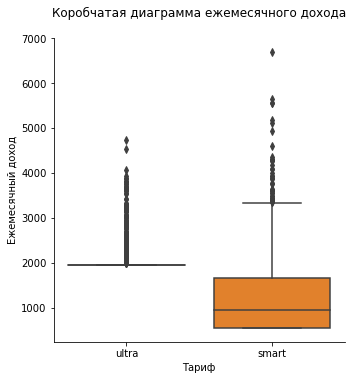

In [78]:
sns.catplot(x="tariff", y='monthly_revenue', kind="box", data=revenue)
plt.title('Коробчатая диаграмма ежемесячного дохода'+ "\n")
plt.xlabel('Тариф')
plt.ylabel('Ежемесячный доход')
plt.show()

Как мы можем увидеть из анализа, в среднем пользователи тарифа `Ультра` приносят почти в 2 раза больше выручки. Пользователи тарифа `Смарт` доплачивают в среднем еще 400 рублей из-за нехватки услуг в рамках их тарифного плана.

Нулевая гипотеза была отвергнута, что означает, что средняя выручка тарифов Ультра и Смарт отличаются.

- Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

H0 - Выручка пользователей из Москвы не отличается<br>
H1 - Отличается

In [79]:
moscow = revenue.query('city == "Москва"')['monthly_revenue']
regions = revenue.query('city != "Москва"')['monthly_revenue']

alpha = .05

results = st.ttest_ind(
    moscow, 
    regions, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4471856469587271
Не получилось отвергнуть нулевую гипотезу


Посчитаем среднюю выручку в Москве и в других регионах

In [80]:
def det_region(city):
    if city == 'Москва': 
        return 'Москва'
    else: 
        return 'Другой регион'
    
revenue['region'] = revenue['city'].apply(det_region)
revenue.pivot_table(index='region', values='monthly_revenue', aggfunc='median')

,monthly_revenue
region,
Другой регион,1513.873047
Москва,1699.357422


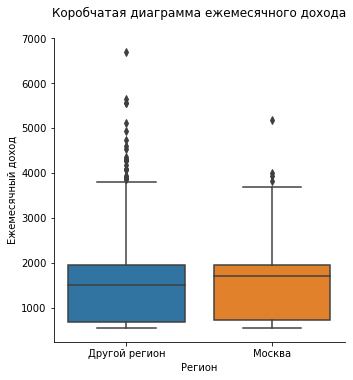

In [81]:
sns.catplot(x="region", y='monthly_revenue', kind="box", data=revenue)
plt.title('Коробчатая диаграмма ежемесячного дохода'+ "\n")
plt.xlabel('Регион')
plt.ylabel('Ежемесячный доход')
plt.show()

Нулевая гипотеза не отвергнута, что означает, что выручка пользователей из Москвы и из других регионов не отличается. 

Если смотреть по значением, то и правда можно сказать, что выручки не отличаются(1699 против 1513 рублей).

##  Общий вывод

По результатам анализа, мы получаем, что доходы от пользователей тарифа `Ультра` больше, чем доходы от пользователей тарифа `Смарт`. В среднем каждый пользователь приносит 1950 рублей и 957 рублей соответственно.

- Как мы выяснили из анализа, пользователи тарифа смарт в среднем каждый месяц доплачивают 407 рублей из-за нехватки услуг в рамках их тарифного плана
- С дорогим тарифом все совсем наоборот, люди пользуются тарифом более свободно, при этом им не нужно доплачивать за услуги, так как не расходуется весь пакет услуг
- Выручка от пользователей из Москвы и других регионов не отличаются, то есть мы можем сказать, что разница незначима(186 рублей)
